In [1]:
from nb_utils import read_commits

import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nb_utils import SAFETENSORS_RELEASE_DATE

# model files per repository and the elapsed days between the commit and safetensor's release date
df = read_commits()

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']



# group by timestamp, and ignore the times, just group based on the date
commits_by_date = df_safetensors.groupby(df_safetensors['date'].dt.floor('D')).size().sort_index()

# add all dates from SAFE TENSORS RELEASE DATE to today
for i in range(0, (pd.Timestamp.today() - SAFETENSORS_RELEASE_DATE).days):
    date = SAFETENSORS_RELEASE_DATE + pd.Timedelta(days=i)
    if date not in commits_by_date.index:
        commits_by_date.loc[date] = 0
commits_by_date = commits_by_date.sort_index()
# name the count as 'count'
commits_by_date.name = 'count'

# Ensure 'files_modified_by_date' has datetime as the index if not already
commits_by_date.index = pd.to_datetime(commits_by_date.index)


commits_by_date

date
2022-09-23    0
2022-09-24    0
2022-09-25    0
2022-09-26    0
2022-09-27    0
             ..
2024-10-27    0
2024-10-28    0
2024-10-29    0
2024-10-30    0
2024-10-31    0
Name: count, Length: 770, dtype: int64

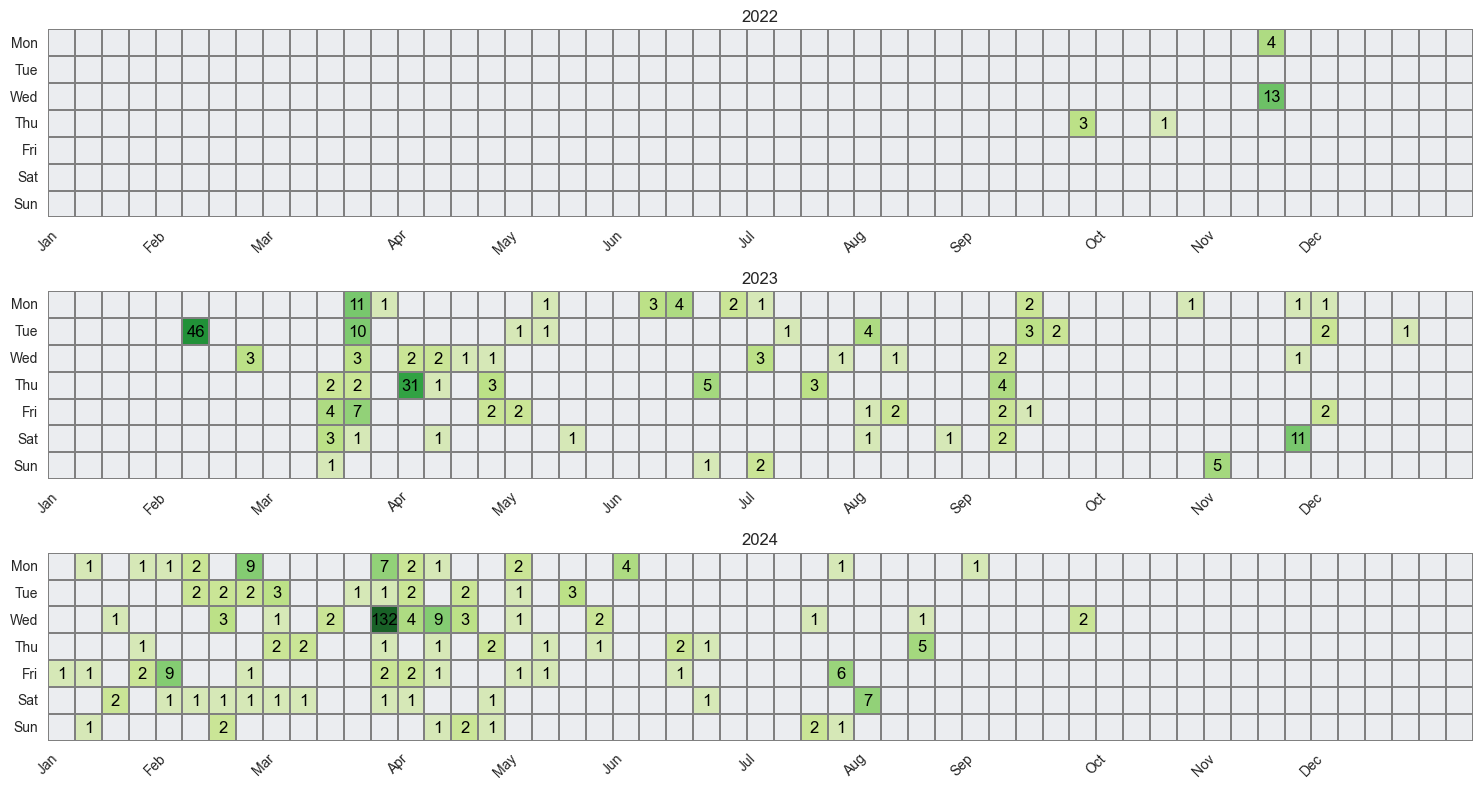

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path


# Define the years for which we want to create heatmaps
years = [2022, 2023, 2024]

# Define a color map similar to GitHub's green color scheme
colors = ["#ebedf0", "#c6e48b", "#7bc96f", "#239a3b", "#196127"]
cmap = LinearSegmentedColormap.from_list("github_green", colors)

# Determine the maximum value across the entire dataset to set a common color range
vmax = commits_by_date.max()
vmin = commits_by_date.min()
# Apply a logarithmic transformation to the data to manage outliers
import numpy as np

# Apply a log transformation to the commits, offsetting by 1 to handle zero values
log_commits_by_date = np.log1p(commits_by_date)  # log(1 + count)

# Determine the max log-transformed value for setting the consistent color range
vmax_log = log_commits_by_date.max()

# Modify the function to add count annotations on non-zero cells

def plot_year_heatmap_with_annotations(year, ax):
    # Create a DataFrame with dates for the specified year and apply log-transformed data
    year_data = log_commits_by_date[log_commits_by_date.index.year == year]
    year_data_original = commits_by_date[commits_by_date.index.year == year]  # Original counts for annotation
    year_data = year_data.reindex(pd.date_range(f"{year}-01-01", f"{year}-12-31"), fill_value=0)
    year_data_original = year_data_original.reindex(pd.date_range(f"{year}-01-01", f"{year}-12-31"), fill_value=0)

    # Create a matrix for days (rows) and weeks (columns) for a horizontal layout
    year_matrix = np.zeros((7, 53))
    year_matrix_original = np.zeros((7, 53))

    for i, (date, value) in enumerate(year_data.items()):
        week = date.isocalendar().week - 1
        day = date.weekday()
        year_matrix[day, week] = value
        year_matrix_original[day, week] = year_data_original[date]  # Original count for annotation

    # Plot the heatmap with log-transformed data
    sns.heatmap(year_matrix, ax=ax, cmap=cmap, cbar=False,
                vmin=0, vmax=vmax_log, linewidths=0.1, linecolor='gray', square=True,
                yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Add annotations for non-zero values
    for row in range(7):
        for col in range(53):
            if year_matrix_original[row, col] > 0:
                ax.text(col + 0.5, row + 0.5, f"{int(year_matrix_original[row, col])}",
                        ha='center', va='center', fontsize=12, color='black')

    # Set title and adjust labels for horizontal orientation
    ax.set_title(f"{year}")
    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    
    # Adjust the month labels along the x-axis
    month_ticks = [0, 4, 8, 13, 17, 21, 26, 30, 34, 39, 43, 47]
    ax.set_xticks(month_ticks)
    ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=45)

# Plot horizontal heatmaps with annotations for non-zero values
fig, axes = plt.subplots(len(years), 1, figsize=(20, 8))

for i, year in enumerate(years):
    plot_year_heatmap_with_annotations(year, axes[i])

plt.tight_layout()

# save as PDF on results folder
plt.savefig(Path('../../results/heatmap4.pdf', bbox_inches='tight'))

plt.show()